In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder ,LabelEncoder
from sklearn.compose import ColumnTransformer
from pyclustering.cluster.kmedoids import kmedoids
from pyclustering.cluster import cluster_visualizer
from pyclustering.utils import calculate_distance_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from scipy.cluster.hierarchy import linkage, dendrogram
import folium
from folium.plugins import MarkerCluster
import warnings
warnings.filterwarnings('ignore')
sns.set_theme(style="darkgrid")

In [109]:
df = pd.read_csv(r"C:\Users\HP\Downloads\program files\python\train.csv")

# df Familiarization
Here we are trying to understand our df , and asking questions like :

How many rows and columns ?  
Are there any duplicates and nulls ?  
What is the type of each column ?

In [110]:
df.head()

Dates        Category                      Descript  \
0  2015-05-13 23:53:00        WARRANTS                WARRANT ARREST   
1  2015-05-13 23:53:00  OTHER OFFENSES      TRAFFIC VIOLATION ARREST   
2  2015-05-13 23:33:00  OTHER OFFENSES      TRAFFIC VIOLATION ARREST   
3  2015-05-13 23:30:00   LARCENY/THEFT  GRAND THEFT FROM LOCKED AUTO   
4  2015-05-13 23:30:00   LARCENY/THEFT  GRAND THEFT FROM LOCKED AUTO   

   DayOfWeek PdDistrict      Resolution                    Address  \
0  Wednesday   NORTHERN  ARREST, BOOKED         OAK ST / LAGUNA ST   
1  Wednesday   NORTHERN  ARREST, BOOKED         OAK ST / LAGUNA ST   
2  Wednesday   NORTHERN  ARREST, BOOKED  VANNESS AV / GREENWICH ST   
3  Wednesday   NORTHERN            NONE   1500 Block of LOMBARD ST   
4  Wednesday       PARK            NONE  100 Block of BRODERICK ST   

            X          Y  
0 -122.425892  37.774599  
1 -122.425892  37.774599  
2 -122.424363  37.800414  
3 -122.426995  37.800873  
4 -122.438738  37.771541

In [111]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Dates       878049 non-null  object 
 1   Category    878049 non-null  object 
 2   Descript    878049 non-null  object 
 3   DayOfWeek   878049 non-null  object 
 4   PdDistrict  878049 non-null  object 
 5   Resolution  878049 non-null  object 
 6   Address     878049 non-null  object 
 7   X           878049 non-null  float64
 8   Y           878049 non-null  float64
dtypes: float64(2), object(7)
memory usage: 60.3+ MB


Here we are adding some columns from Dates columns that will help us later in the analysis

In [112]:
df['Dates'] = pd.to_datetime(df['Dates'])
df['Year'] = df['Dates'].dt.year
df['Month'] = df['Dates'].dt.month
df['Day'] = df['Dates'].dt.weekday
df['Hour'] = df['Dates'].dt.hour

In [113]:
r , c = df.shape
print(f'There are {r} rows and {c} columns')

There are 878049 rows and 13 columns


In [114]:
start_date = df['Year'].min()
end_date = df['Year'].max()
print(f'The df is from {start_date} to {end_date}')

The df is from 2003 to 2015


In [115]:
df.isnull().sum()

Dates         0
Category      0
Descript      0
DayOfWeek     0
PdDistrict    0
Resolution    0
Address       0
X             0
Y             0
Year          0
Month         0
Day           0
Hour          0
dtype: int64

In [116]:
df.duplicated(subset=df.columns).sum()

np.int64(2323)

In [117]:
duplicates = df[df.duplicated(subset=df.columns)]
df= df.drop_duplicates(subset=df.columns)

# Exploratory data Analysis 
In this phase we will try to what the df telling us 

Checking for outliers

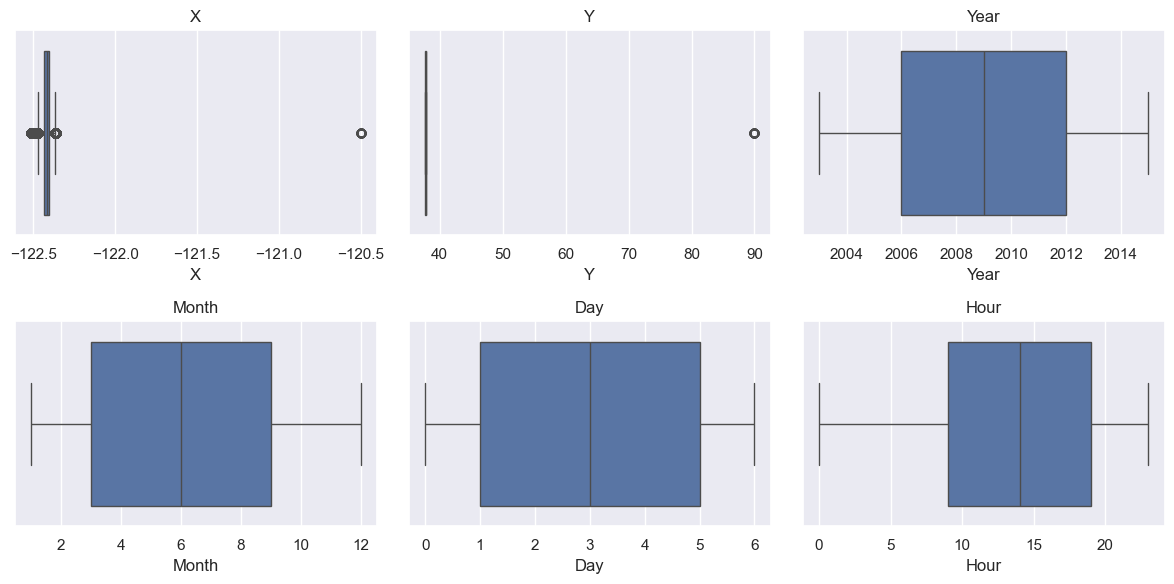

In [118]:
numeric_cols = df.select_dtypes(include='number').columns

plt.figure(figsize=(12, 6))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, 3, i) 
    sns.boxplot(x=df[col])
    plt.title(col)

plt.tight_layout()
plt.show()


Removing outliers for X and Y columns ...

In [119]:
Q1_x = df['X'].quantile(0.25)
Q3_x = df['X'].quantile(0.75)
IQR_x = Q3_x - Q1_x
lower_bound_X = Q1_x - 1.5 * IQR_x
upper_bound_X = Q3_x + 1.5 * IQR_x

Q1_y = df['Y'].quantile(0.25)
Q3_y = df['Y'].quantile(0.75)
IQR_y = Q3_y - Q1_y
lower_bound_Y = Q1_y - 1.5 * IQR_y
upper_bound_Y = Q3_y + 1.5 * IQR_y


df= df[(df['X'] >= lower_bound_X) & (df['X'] <= upper_bound_X) & 
              (df['Y'] >= lower_bound_Y) & (df['Y'] <= upper_bound_Y)]

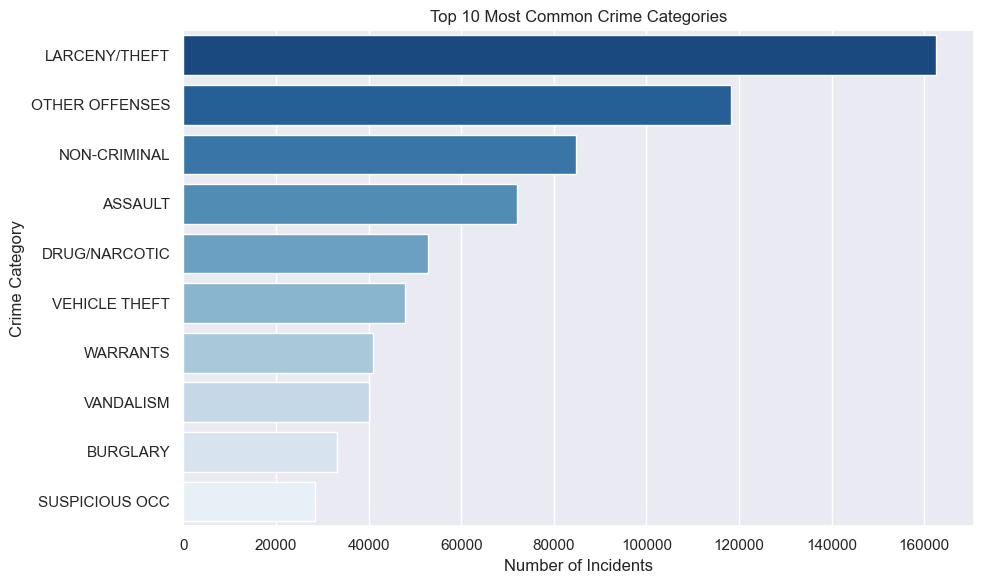

In [120]:
top_crimes = df['Category'].value_counts().head(10)

plt.figure(figsize=(10,6))
sns.barplot(x=top_crimes.values, y=top_crimes.index, palette='Blues_r')
plt.title('Top 10 Most Common Crime Categories')
plt.xlabel('Number of Incidents')
plt.ylabel('Crime Category')
plt.tight_layout()
plt.show()

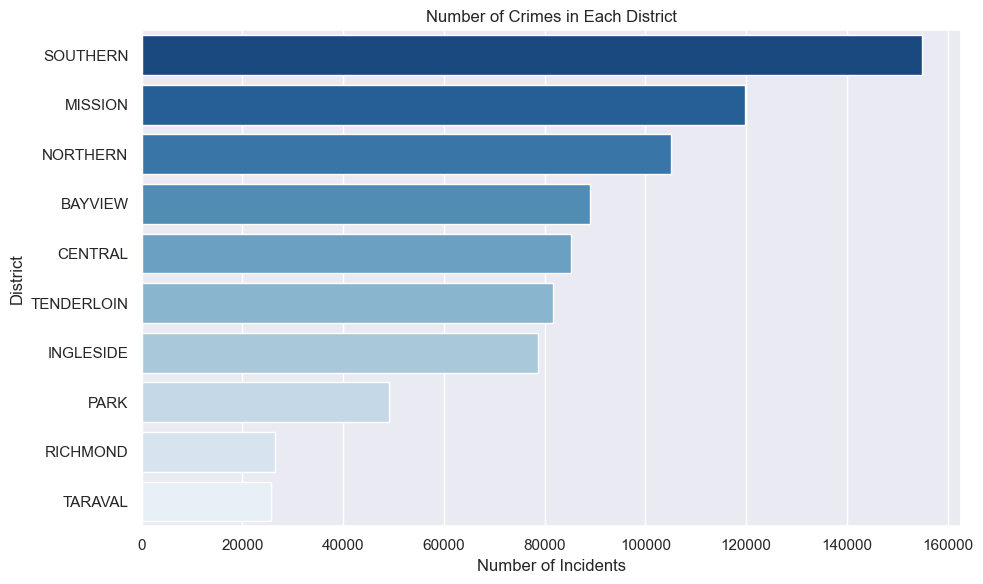

In [121]:
plt.figure(figsize=(10,6))
district_counts = df['PdDistrict'].value_counts()
sns.barplot(x=district_counts.values, y=district_counts.index, palette='Blues_r')
plt.title('Number of Crimes in Each District')
plt.xlabel('Number of Incidents')
plt.ylabel('District')
plt.tight_layout()
plt.show()

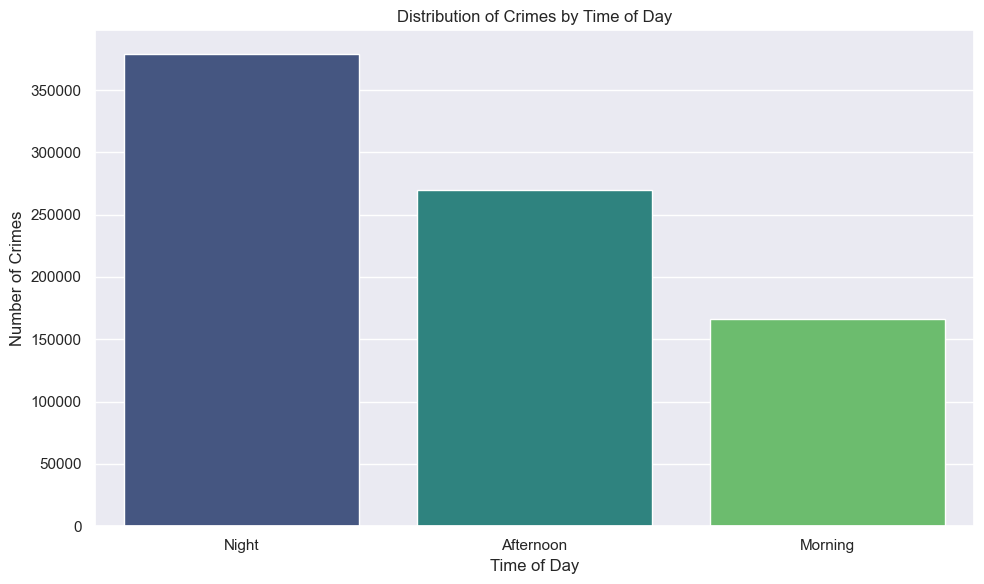

In [122]:
def categorize_time(hour):
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    else:
        return 'Night'

df['TimeOfDay'] = df['Hour'].apply(categorize_time)

plt.figure(figsize=(10,6))
sns.countplot(x='TimeOfDay', data=df, palette='viridis')
plt.title('Distribution of Crimes by Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Number of Crimes')
plt.tight_layout()
plt.show()

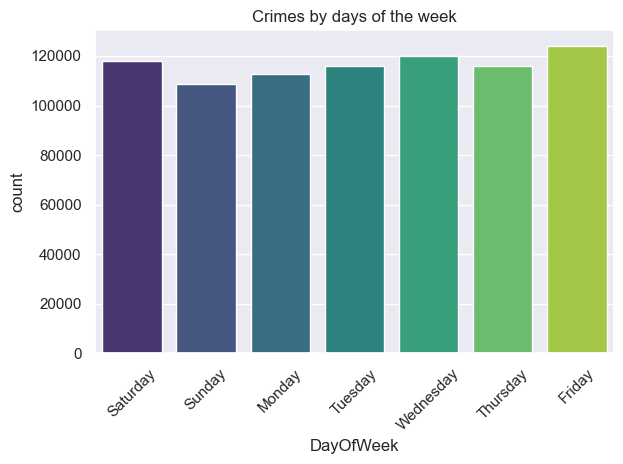

In [123]:
week_days = ['Saturday','Sunday','Monday','Tuesday','Wednesday','Thursday','Friday']
sns.countplot(data=df, x='DayOfWeek', order=week_days, palette='viridis')
plt.xticks(rotation=45)
plt.title('Crimes by days of the week')
plt.tight_layout() 
plt.show()

In this chart the df is telling us that Friday    
 is the most day with crimes during the week

<Axes: xlabel='Hour', ylabel='count'>

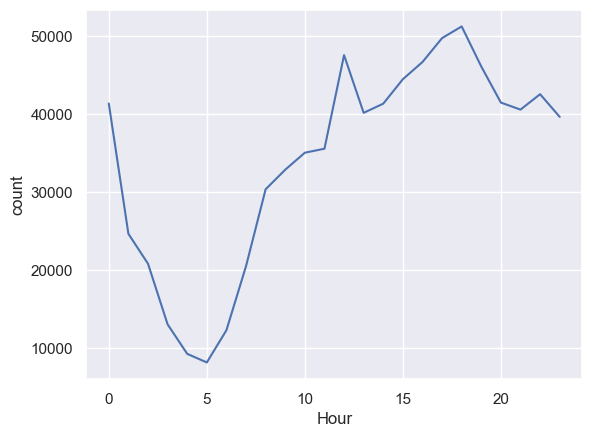

In [124]:
sns.lineplot(df['Hour'].value_counts())

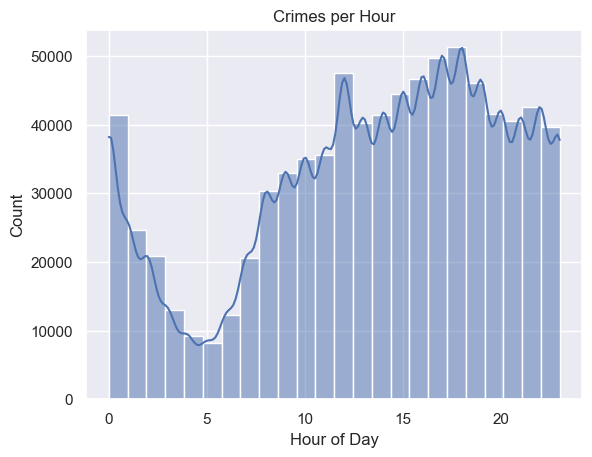

In [125]:
sns.histplot(df['Hour'], bins=24, kde=True)
plt.title('Crimes per Hour')
plt.xlabel('Hour of Day')
plt.show()

In [126]:
sf_map = folium.Map(location=[37.77, -122.42], zoom_start=12)

sample_df = df.sample(5000, random_state=1) 

marker_cluster = MarkerCluster().add_to(sf_map)

for idx, row in sample_df.iterrows():
    folium.Marker(
        location=[row['Y'], row['X']],
        popup=row['PdDistrict'] if 'PdDistrict' in df.columns else None
    ).add_to(marker_cluster)

sf_map

What i figured out from these visuls that most of the crimes are thefts  
happened in southern region at night   
and Friday has highest rates of crimes because it is the holiday and most of the people   are out so most of the houses are empty and easy to get robbed.

# Data Mining 

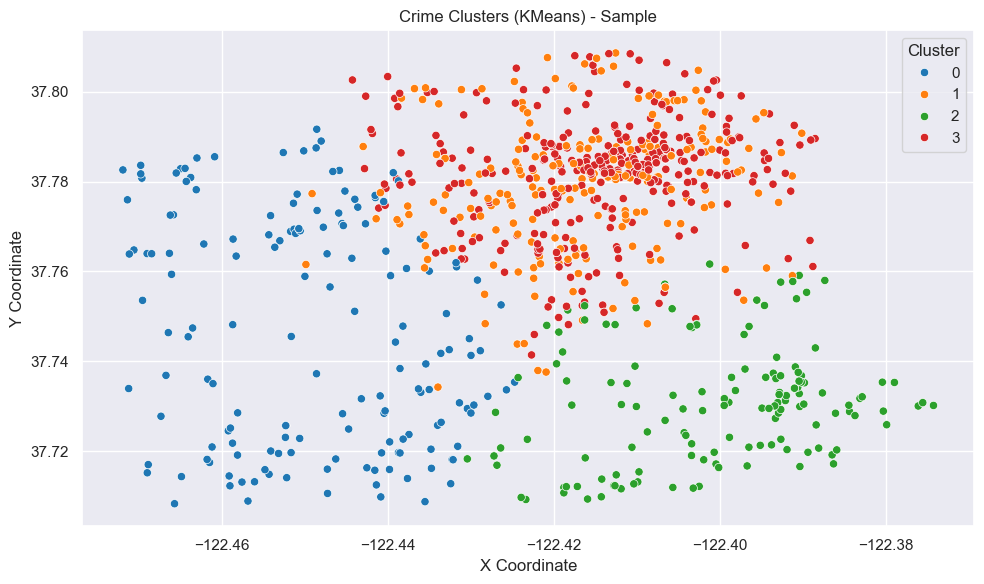

In [127]:
sample_df = df[['X', 'Y', 'Hour']].sample(n=1000, random_state=42)

scaler = StandardScaler()
sample_scaled = scaler.fit_transform(sample_df)

kmeans = KMeans(n_clusters=4, random_state=42)
sample_df['Cluster'] = kmeans.fit_predict(sample_scaled)

plt.figure(figsize=(10,6))
sns.scatterplot(x='X', y='Y', hue='Cluster', data=sample_df, palette='tab10', legend='full')
plt.title('Crime Clusters (KMeans) - Sample')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.tight_layout()

plt.show()


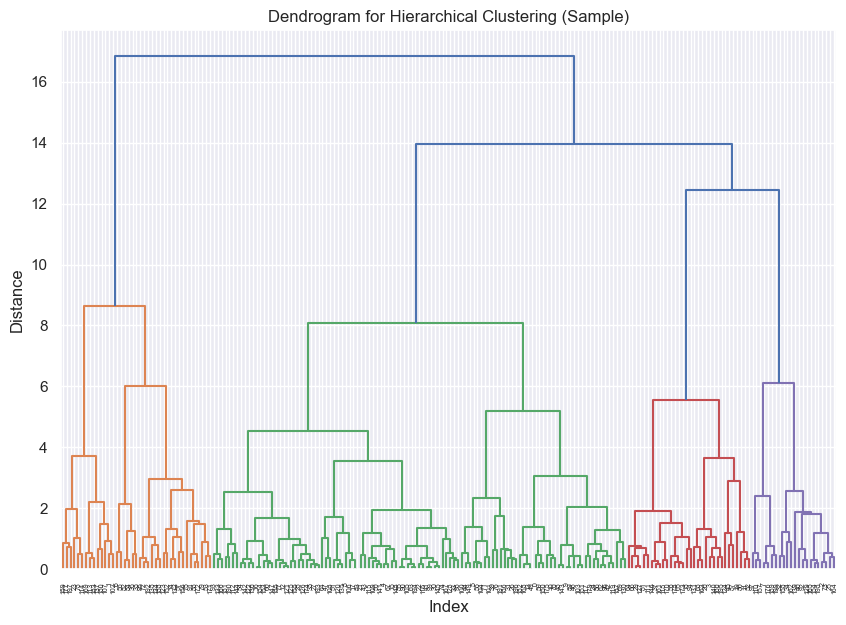

In [128]:
sample_df = sample_scaled[:200]

Z = linkage(sample_df, method='ward')

plt.figure(figsize=(10, 7))
dendrogram(Z)
plt.title("Dendrogram for Hierarchical Clustering (Sample)")
plt.xlabel("Index")
plt.ylabel("Distance")
plt.show()